<a href="https://colab.research.google.com/github/ashish-ty/Image_Restoration/blob/main/Combined_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d jessicali9530/lfw-dataset

100% 112M/112M [00:00<00:00, 154MB/s] 



In [7]:
! unzip lfw-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [8]:
face_images = glob.glob('/content/lfw-deepfunneled/lfw-deepfunneled/**/*.jpg') 

In [9]:
import pickle

images = np.zeros((len(face_images),120,120,3))
# print(images)
for i in range(len(face_images)):
  img = tf.keras.preprocessing.image.load_img(face_images[i], target_size=(120,120,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  images[i] = img

In [10]:
#Splitting
import random

random_nums = random.sample(range(0,1000),100)
x_test = np.zeros((100,120,120,3))
x_train = np.zeros((900,120,120,3))


tt=0
tr=0
# print(images)
for i in range(0,1000):
  if i not in random_nums:
    x_train[tt] = images[i]
    tt = tt + 1
  else:
    x_test[tr] = images[i]
    tr = tr + 1


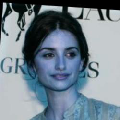

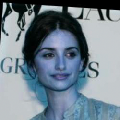

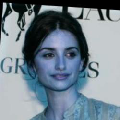

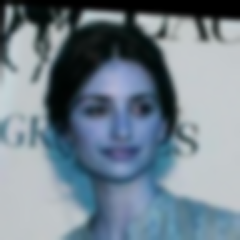

In [11]:
#Training Dataset

noise_fact_val = 30/255

x_train_noise = x_train + noise_fact_val*np.random.normal(loc=0, scale=1.0,size=x_train.shape)
x_test_noise = x_test + noise_fact_val*np.random.normal(loc=0, scale=1.0,size=x_test.shape) 

cv2_imshow(x_train[0])
cv2_imshow(x_train_noise[0])

x_train_blur=x_train_noise
for i in range(0,900):
  x_train_blur[i]=cv2.GaussianBlur(x_train_noise[i], (7, 7), 0)

x_test_blur=x_test_noise
for i in range(0,100):
  x_test_blur[i]=cv2.GaussianBlur(x_test_noise[i], (7, 7), 0)

x_test_low = np.zeros((100,240,240,3))
x_train_low = np.zeros((900,240,240,3))
scale_y=2
for i in range(0,900):
  x_train_low[i]=cv2.resize(x_train_blur[i], None,fx=scale_y, fy=scale_y, interpolation=cv2.INTER_CUBIC)


for i in range(0,100):
  x_test_low[i]=cv2.resize(x_test_blur[i],None, fx=scale_y, fy=scale_y, interpolation=cv2.INTER_CUBIC)

cv2_imshow(x_train[0])
cv2_imshow(x_train_low[0])



In [12]:
model = models.Sequential()

model.add(layers.Conv2D(64, (9, 9), strides = 1, padding = 'same', activation='relu',input_shape=(240,240,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (7, 7), strides = 1, padding = 'same',activation='relu'))
# model.add(layers.UpSampling2D())

model.add(layers.Conv2D(32, (5, 5), strides = 1, padding = 'same',activation='relu'))
model.add(layers.Conv2D(3, (3, 3), strides = 1, padding = 'same',activation='relu'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 64)      15616     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      200768    
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 32)      51232     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 3)       867       
                                                                 
Total params: 268,483
Trainable params: 268,483
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss = 'mse', optimizer = 'adam',metrics=['accuracy'])

with tf.device('/device:GPU:0'):
    model.fit(x_train_low.reshape(-1, 240, 240, 3), x_train.reshape(-1, 120, 120, 3), epochs = 500, batch_size = 128, 
              validation_data = (x_test_low.reshape(-1, 240, 240, 3), x_test.reshape(-1, 120, 120, 3)))

Epoch 1/500
8/8 [==============================] - 7s 802ms/step - loss: 5545.4106 - accuracy: 0.6883 - val_loss: 3628.6653 - val_accuracy: 0.3433
Epoch 2/500
8/8 [==============================] - 6s 779ms/step - loss: 1915.1112 - accuracy: 0.4576 - val_loss: 1086.9736 - val_accuracy: 0.6801
Epoch 3/500
8/8 [==============================] - 6s 783ms/step - loss: 826.7324 - accuracy: 0.6893 - val_loss: 603.1667 - val_accuracy: 0.7096
Epoch 4/500
8/8 [==============================] - 6s 778ms/step - loss: 644.9303 - accuracy: 0.7497 - val_loss: 520.4409 - val_accuracy: 0.7628
Epoch 5/500
8/8 [==============================] - 6s 783ms/step - loss: 556.1544 - accuracy: 0.7207 - val_loss: 459.4809 - val_accuracy: 0.7710
Epoch 6/500
8/8 [==============================] - 6s 784ms/step - loss: 622.4918 - accuracy: 0.7547 - val_loss: 440.4377 - val_accuracy: 0.7575
Epoch 7/500
8/8 [==============================] - 6s 783ms/step - loss: 410.8532 - accuracy: 0.7626 - val_loss: 331.7953 - va

In [15]:

#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

In [16]:
num = 10
org, temp = get_samples(x_train, num)
low_res = x_train_low[temp]
preds = model.predict(low_res)

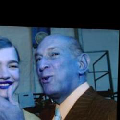

In [21]:
cv2_imshow(org[0])

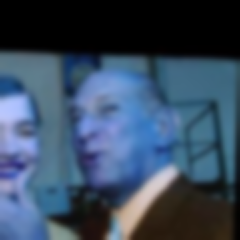

In [22]:
cv2_imshow(low_res[0])


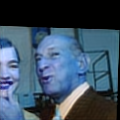

In [23]:
cv2_imshow(preds[0])